In [53]:
import numpy as np
import networkx as nx
import random as rd
import math

In [111]:
class PoW:

    def __init__(self, ntwk, params):
        self.ntwk = ntwk
        self.N = len(ntwk)
        self.N_active = len([node for node in ntwk.nodes() if self.ntwk.nodes[node]["active"]])
        # Is the prev_block important here?
        self.global_blockchain = {0: {"level": 0, "prev_block": 0, "miner": -1, "time_created": 0, "n_transactions": 0, "children" : []}}
        self.global_levels = {0: [0]}
        self.time = 0
        self.newest_block_id = 0
        self.signals = {}
        self.changed_blockchain_nodes = []
        self.params = params
        self.transaction_pool = 0
        self.decentralization = {
            "HHI" : [],
            "gini" : [],
            "entropy" : [],
            "naka" : []
        }
        self.scalability = {
            "TPS" : [],
            "storage_ratio" : []
        }
        self.security = {
            "fork_rate" : [],
            "fork_ratio" : [],
            "orphaned_ratio" : []
        }

    def randomSignalNoise(self):
        # Random Noise CANNOT be negative
        return np.random.poisson(self.params["avg_signal_noise"])

    def addNewTransactions(self):
        self.transaction_pool += np.random.poisson(self.params["avg_transaction_rate"])

    # Create number of transactions for nodes to add to the block they're mining on
    def getNumTransactions(self):
        return max(1, min(self.transaction_pool - np.random.poisson(4 * self.params["avg_transaction_rate"]), self.params["max_n_transactions"] - np.random.poisson(self.params["avg_transaction_rate"])))

    # Returns total power of all nodes
    def getTotalPower(self):
        return sum(self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes())

    # Returns total power of all active nodes currently
    def getTotalActivePower(self):
        return sum(self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes() if self.ntwk.nodes[node]["active"])

    # Deciding whether to activate or deactivate a node
    # This can depend on several factors - power of node, whether they successfully mined a block, the reward and difficulty, and other things
    def nodeActivateOrDeactivate(self):
        for node in self.ntwk.nodes():
            if self.ntwk.nodes[node]["active"]:
                # Here, prob(deactivating) = q * (1 - x), where x is hashrate share
                if rd.random() < (1 - (self.ntwk.nodes[node]["power"]/self.getTotalPower())) * self.params["deactivate"]:
                    self.ntwk.nodes[node]["active"] = False
                    self.N_active -= 1
            else:
                # Here, prob(activating) = p * x + q, where x is hashrate share
                if rd.random() < (self.ntwk.nodes[node]["power"] * self.params["activate"])/self.getTotalPower() + self.params["deactivate"]:
                    self.ntwk.nodes[node]["active"] = True
                    self.N_active += 1
                    self.restartNode(node)
            # Overall, prob(activating) > prob(deactivating) here for all values of params for all nodes.

    def sendSignal(self, node, block_id):
        # Send signal to all neighbors of node
        for nb in self.ntwk.neighbors(node):
            # Calculate arrival time of signal for neighbor "nb"
            arrival_time = self.time + round(self.global_blockchain[block_id]["n_transactions"]/self.ntwk[node][nb]["bandwidth"]) + self.randomSignalNoise()

            # Handle missing arrival_time and nb cases
            if not (arrival_time in self.signals):
                self.signals[arrival_time] = {}
            if not (nb in self.signals[arrival_time]):
                self.signals[arrival_time][nb] = []

            # Add block_id in "arrival_time" at correct neighbor "nb"
            self.signals[arrival_time][nb].append(block_id)

    # Adds the new block to both global and node's local blockchain and updates both global and node's local levels
    def addNewBlock(self, node):
        # Level to add newly mined block = Level of block that node was mining on + 1
        level = self.global_blockchain[self.ntwk.nodes[node]["mining"]["block_id"]]["level"] + 1
        # or, as it better be mining on longest chain block, level = max(list(self.ntwk.nodes[node]["local_levels"])) + 1

        # Creates new block and updates global_blockchain
        self.global_blockchain[self.newest_block_id] = {"level": level, "prev_block": self.ntwk.nodes[node]["mining"]["block_id"], "miner": node, "time_created": self.time, "n_transactions": self.ntwk.nodes[node]["mining"]["n_transactions"], "children" : []}
        
        # Subtract n_transactions away from transaction_pool
        self.transaction_pool -= self.ntwk.nodes[node]["mining"]["n_transactions"]

        # Adds itself to the "children" of its prev_block
        self.global_blockchain[self.ntwk.nodes[node]["mining"]["block_id"]]["children"].append(self.newest_block_id)
        
        # Updates global_levels
        if not (level in self.global_levels):
            self.global_levels[level] = []
        self.global_levels[level].append(self.newest_block_id)

        # Updates local_blockchain
        self.ntwk.nodes[node]["local_blockchain"][self.newest_block_id] = self.time

        # Updates local_levels (note that the condition must always be true, but I still added the "if" condition just in case)
        if not (level in self.ntwk.nodes[node]["local_levels"]):
            self.ntwk.nodes[node]["local_levels"][level] = []
        self.ntwk.nodes[node]["local_levels"][level].append(self.newest_block_id)

        # Adds node to changed_blockchain_nodes
        self.changed_blockchain_nodes.append(node)

    def verifyAddingBlockToNode(self, node, level, block_id) -> bool:
        if (level - 1) in self.ntwk.nodes[node]["local_levels"]:
            for block in self.ntwk.nodes[node]["local_levels"][level - 1]:
                if block == self.global_blockchain[block_id]["prev_block"]:
                    return True
        return False

    # CHANGE LOCAL BLOCKCHAIN TO ONLY HAVE BLOCK ID AND TIME IT RECEIVED IT
    def addBlockToLocalBlockchainFromSignal(self, node, block_id):
        level = self.global_blockchain[block_id]["level"]

        if self.verifyAddingBlockToNode(node, level, block_id):
            self.ntwk.nodes[node]["local_blockchain"][block_id] = self.time

            if not (level in self.ntwk.nodes[node]["local_levels"]):
                self.ntwk.nodes[node]["local_levels"][level] = []
            self.ntwk.nodes[node]["local_levels"][level].append(block_id)
            
            # Adds node to changed_blockchain_nodes
            self.changed_blockchain_nodes.append(node)

        else: # Adds block_id to storage with correct level key
            if not (level in self.ntwk.nodes[node]["storage"]):
                self.ntwk.nodes[node]["storage"][level] = []
            self.ntwk.nodes[node]["storage"][level].append(block_id)
            # Adding this node to changed_blockchain_nodes after a block has been added into its storage is unnecessary.
            # If and when a storage block does finally find a place to fit into the local blockchain,
            # That would only happen after the local blockchain has been changed by some block getting added in it,
            # And in that case, the node would be added into changed_blockchain_nodes anyway and the storage would get fixed.

    def tryAddBlockToLocalBlockchainFromStorage(self, node, level, block_id):
        if self.verifyAddingBlockToNode(node, level, block_id):
            self.ntwk.nodes[node]["local_blockchain"][block_id] = self.time

            if not (level in self.ntwk.nodes[node]["local_levels"]):
                self.ntwk.nodes[node]["local_levels"][level] = []
            self.ntwk.nodes[node]["local_levels"][level].append(block_id)
            
            # Adds node to changed_blockchain_nodes
            self.changed_blockchain_nodes.append(node)

            self.ntwk.nodes[node]["storage"][level].remove(block_id)
            
    # Handles mining
    def allMining(self):
        for node in self.ntwk.nodes():
            # Checks mining status of "node" and if it is active
            if self.time == self.ntwk.nodes[node]["mining"]["mine_time"] and self.ntwk.nodes[node]["active"]:
                # Increase newest block id by 1
                self.newest_block_id += 1
                # Add new block to global and local blockchains
                self.addNewBlock(node)
                # Send signal to all neighbors
                self.sendSignal(node, self.newest_block_id)

    def handleSignals(self):
        # If there exist signals supposed to arrive at current time
        if self.time in self.signals:
            # For all nodes supposed to receive those signals
            for node in self.signals[self.time]:
                # Add all blocks that the particular node was supposed to receive to the node local blockchain
                for block_id in self.signals[self.time][node]:
                    self.addBlockToLocalBlockchainFromSignal(node, block_id)
            # Free up memory by deleting the current time signals list
            del self.signals[self.time]

    # For a node, checks all block ids in storage and tries to add them in local blockchain
    def checkNodeStorage(self, node):
        levels = list(self.ntwk.nodes[node]["storage"].keys())
        levels.sort()
        for level in levels:
            for block_id in self.ntwk.nodes[node]["storage"][level]:
                self.tryAddBlockToLocalBlockchainFromStorage(node, level, block_id)

    # Checks if a node is mining on the longest chain block, and restarts it if it is not
    def checkNodeRestart(self, node):
        highest_level = max(list(self.ntwk.nodes[node]["local_levels"]))
        longest_chain_block_id = self.ntwk.nodes[node]["local_levels"][highest_level][0]

        # If the block it is mining on isn't longest_chain_block_id, then restart mining on this new block
        if self.ntwk.nodes[node]["mining"]["block_id"] != longest_chain_block_id:
            self.ntwk.nodes[node]["mining"]["block_id"] = longest_chain_block_id
            self.ntwk.nodes[node]["mining"]["mine_time"] = self.time + round(np.random.exponential(self.params["avg_mine_time"] * self.getTotalActivePower()/self.ntwk.nodes[node]["power"]))
            self.ntwk.nodes[node]["mining"]["n_transactions"] = self.getNumTransactions()

    # Restarts a node forcefully
    def restartNode(self, node):
        highest_level = max(list(self.ntwk.nodes[node]["local_levels"]))
        longest_chain_block_id = self.ntwk.nodes[node]["local_levels"][highest_level][0]
        self.ntwk.nodes[node]["mining"]["block_id"] = longest_chain_block_id
        self.ntwk.nodes[node]["mining"]["mine_time"] = self.time + round(np.random.exponential(self.params["avg_mine_time"] * self.getTotalActivePower()/self.ntwk.nodes[node]["power"]))
        self.ntwk.nodes[node]["mining"]["n_transactions"] = self.getNumTransactions()

    # For every changed blockchain nodes, checks its storage and whether it requires restart
    def checkNodes(self):
        for _ in range(len(self.changed_blockchain_nodes)):
            # Pop the node out to free up memory
            node = self.changed_blockchain_nodes.pop(0)
            self.checkNodeStorage(node)
            # You only need to restart if the node is active, as an inactive node becoming active will get restarted anyway
            if self.ntwk.nodes[node]["active"]: self.checkNodeRestart(node)

    def getLongestChain(self):
        longest_chain = []

        # Get longest chain block id, which is the first block in the highest global level
        block_id = self.global_levels[max(list(self.global_levels))][0]

        # WHY WAS THIS WRITTEN IN PLACE OF ABOVE BEFORE? IT HAS LOCAL LEVELS NOT GLOBAL, AND node VARIABLE ISN'T EVEN DEFINED
        # block_id = self.ntwk.nodes[node]["local_levels"][max(list(self.global_levels))][0]

        while block_id != 0:
            longest_chain.append(block_id)
            block_id = self.global_blockchain[block_id]["prev_block"]
        
        return longest_chain
 
    def getActivePowers(self):
        total_active_power = self.getTotalActivePower()
        power_values = [self.ntwk.nodes[node]["power"]/total_active_power for node in self.ntwk.nodes() if self.ntwk.nodes[node]["active"]]
        return power_values

    def topActivePowersSquaredSum(self, p):
        power_values = self.getActivePowers()
        power_values.sort(reverse=True)
        return sum(power**2 for power in power_values[:int(len(power_values)*p/100)])

    def measureHHI(self):
        return 1 - self.topActivePowersSquaredSum(10)

    def measureNaka(self):
        power_values = self.getActivePowers()
        power_values.sort(reverse=True)
        power_sum = 0
        i = 0
        while (power_sum < 0.51):
            power_sum += power_values[i]
            i += 1
        return i/self.N_active

    def measureEntropy(self):
        power_values = self.getActivePowers()
        return - sum(power * np.log2(power) for power in power_values)/np.log2(self.N_active)

    def measureGini(self):
        power_values = self.getActivePowers()
        gini = 0
        for i in range(self.N_active - 1):
            for j in range(i + 1, self.N_active):
                gini += abs(power_values[i] - power_values[j])
        return 1 - gini/self.N_active

    def measureTPS(self):
        # self.time will not be 0 as it is incremented to 1 at the start of the very first iteration
        return sum(self.global_blockchain[block_id]["n_transactions"] for block_id in self.getLongestChain())/self.time

    # Ratio of total number of blocks in storage across all nodes to total number of blocks
    def measureStorageRatio(self):
        if self.newest_block_id == 0 : return 0
        return sum(len(self.ntwk.nodes[node]["storage"][level]) for node in self.ntwk.nodes() for level in self.ntwk.nodes[node]["storage"])/self.newest_block_id

    # Two measures - Rate of forks; and Ratio of number of forks to total number of blocks
    def measureForkRateAndRatio(self):
        if self.newest_block_id == 0 : return {"rate" : 0, "ratio" : 0}
        func = lambda l : l - 1 if l >= 2 else 0
        forks = sum(func(len(self.global_blockchain[block_id]["children"])) for block_id in self.global_blockchain)
        return {"rate" : forks/self.time, "ratio" : forks/self.newest_block_id}

    # Ratio of number of orphaned blocks to total number of blocks
    def measureOrphanedBlocksRatio(self):
        if self.newest_block_id == 0 : return 0
        return (self.newest_block_id - len(self.getLongestChain()))/self.newest_block_id

    # Measure the distribution of lengths of chains that have been reverted and abandoned
    def measureRevertRate(self):
        pass

    # Check the consensus on blockchain - till when do they all agree and by how much?
    def measureConsensus(self):
        pass

    def measureDecentralization(self):
        self.decentralization["HHI"].append(self.measureHHI())
        self.decentralization["gini"].append(self.measureGini())
        self.decentralization["naka"].append(self.measureNaka())
        self.decentralization["entropy"].append(self.measureEntropy())

    def measureScalability(self):
        self.scalability["TPS"].append(self.measureTPS())
        self.scalability["storage_ratio"].append(self.measureStorageRatio())

    def measureSecurity(self):
        fork_measures = self.measureForkRateAndRatio()
        self.security["fork_rate"].append(fork_measures["rate"])
        self.security["fork_ratio"].append(fork_measures["ratio"])
        self.security["orphaned_ratio"].append(self.measureOrphanedBlocksRatio())

    def runMeasures(self):
        self.measureDecentralization()
        self.measureScalability()
        self.measureSecurity()

    def initializeNetwork(self):
        for node in self.ntwk.nodes():
            self.ntwk.nodes[node]["mining"] = {}
            self.ntwk.nodes[node]["mining"]["block_id"] = 0
            self.ntwk.nodes[node]["mining"]["mine_time"] = self.time + round(np.random.exponential(self.params["avg_mine_time"] * self.getTotalActivePower()/self.ntwk.nodes[node]["power"]))
            self.ntwk.nodes[node]["mining"]["n_transactions"] = self.getNumTransactions()
            self.ntwk.nodes[node]["local_blockchain"] = {0: 0}
            self.ntwk.nodes[node]["local_levels"] = {0: [0]}
            self.ntwk.nodes[node]["storage"] = {}

    def runSimulation(self):
        self.addNewTransactions()
        self.initializeNetwork()
        while (self.time < self.params["run_time"]):
            self.time += 1
            self.addNewTransactions()
            self.allMining()
            self.handleSignals()
            # self.measures() should go here as self.checkNodes() deletes some data like storage that self.measure() might need
            self.runMeasures()
            self.checkNodes()

In [80]:
class Network:

    def __init__(self, n):
        self.n = n

    def createGraph(self):
        self.ntwk = nx.complete_graph(self.n)
        
    def assignPower(self):
        for node in self.ntwk.nodes():
            self.ntwk.nodes[node]["power"] = np.random.pareto(1.5) + 1

    def assignWeights(self):
        for edge in self.ntwk.edges:
            self.ntwk.edges[edge]["bandwidth"] = 300/np.random.lognormal(1,0.7)

    def assignActiveOrInactive(self):
        for node in self.ntwk.nodes():
            self.ntwk.nodes[node]["active"] = (np.random.random() < 0.25)

    def createNetwork(self):
        self.createGraph()
        self.assignPower()
        self.assignWeights()
        self.assignActiveOrInactive()
        self.getStats()

    def getStats(self):
        total_power = sum(self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes())
        print(f"Total Power : {total_power}")
        print(f"Max power : {max([self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()])}")
        print(f"Max power share : {max([self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()])/total_power}")
        print(f"Min power : {min([self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()])}")
        print(f"Min power share : {min([self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()])/total_power}")
        print(f"Max bandwidth : {max([self.ntwk.edges[edge]["bandwidth"] for edge in self.ntwk.edges()])}")
        print(f"Min bandwidth : {min([self.ntwk.edges[edge]["bandwidth"] for edge in self.ntwk.edges()])}")

    def getNetwork(self):
        return self.ntwk

In [81]:
net = Network(100)
net.createNetwork()
ntwk = net.getNetwork()

Total Power : 323.4014352688053
Max power : 36.622136668087954
Max power share : 0.11324048898437421
Min power : 1.0027287878852331
Min power share : 0.0031005699991769778
Max bandwidth : 1354.3683018137062
Min bandwidth : 7.974891896837443


In [ ]:
params = {
    "run_time" : 10000,
    "avg_mine_time" : 100,
    "max_n_transactions" : 5000,
    "avg_signal_noise" : 5,
    "activate" : 0.01,
    "deactivate" : 0.01,
    "avg_transaction_rate" : 50
}

In [91]:
sim = PoW(ntwk, params)

In [84]:
print(sim.getActivePowers())

[0.023340435722741405, 0.02026954738001999, 0.012688970426371264, 0.036148202486436645, 0.015296214879630185, 0.013889177809005667, 0.036287976983841765, 0.016377603266663966, 0.014116965878539455, 0.02332320647295873, 0.020072004494333037, 0.12566370893509857, 0.019376714581485485, 0.060540730545479426, 0.07370837812988901, 0.02594169613890834, 0.012986452419456297, 0.01822716549129642, 0.02938763425147846, 0.014353654692959333, 0.015147187644688555, 0.052875934335911326, 0.03922403956987511, 0.029119743303158314, 0.03380751414129618, 0.07770819529984203, 0.03704213493940305, 0.03979371852811668, 0.04412151375807956, 0.019163577493035804]


In [92]:
sim.runSimulation()

In [93]:
print(sim.global_blockchain)

{0: {'level': 0, 'prev_block': 0, 'miner': -1, 'time_created': 0, 'n_transactions': 0, 'children': [1, 4, 27, 50]}, 1: {'level': 1, 'prev_block': 0, 'miner': 20, 'time_created': 129, 'n_transactions': 1, 'children': [2, 3]}, 2: {'level': 2, 'prev_block': 1, 'miner': 80, 'time_created': 228, 'n_transactions': 4961, 'children': [5]}, 3: {'level': 2, 'prev_block': 1, 'miner': 11, 'time_created': 256, 'n_transactions': 4956, 'children': []}, 4: {'level': 1, 'prev_block': 0, 'miner': 47, 'time_created': 306, 'n_transactions': 1, 'children': [7]}, 5: {'level': 3, 'prev_block': 2, 'miner': 46, 'time_created': 378, 'n_transactions': 4952, 'children': [6]}, 6: {'level': 4, 'prev_block': 5, 'miner': 52, 'time_created': 651, 'n_transactions': 4948, 'children': [8, 9]}, 7: {'level': 2, 'prev_block': 4, 'miner': 47, 'time_created': 812, 'n_transactions': 4944, 'children': [11]}, 8: {'level': 5, 'prev_block': 6, 'miner': 52, 'time_created': 832, 'n_transactions': 4955, 'children': [10]}, 9: {'level'

In [100]:
print(sim.ntwk.nodes[2]["local_blockchain"])

{0: 0, 1: 131, 2: 279, 5: 393, 3: 527, 6: 679, 8: 855, 9: 890, 10: 1077, 12: 1172, 13: 1172, 14: 1207, 15: 1262, 17: 1479, 18: 1507, 20: 1645, 21: 1728, 22: 1990, 23: 2198, 24: 2409, 26: 2589, 27: 2604, 28: 2684, 29: 2832, 31: 2877, 30: 2885, 33: 3007, 34: 3007, 35: 3019, 38: 3166, 39: 3608, 40: 3608, 41: 3618, 42: 3706, 44: 3744, 43: 3749, 45: 4001, 46: 4330, 47: 4604, 49: 4643, 48: 4658, 50: 4686, 51: 4761, 52: 4876, 54: 4929, 55: 4931, 53: 4940, 57: 5172, 58: 5402, 59: 5637, 60: 5680, 61: 5702, 62: 5854, 63: 5959, 64: 6271, 65: 6271, 66: 6399, 67: 6402, 68: 6423, 69: 6455, 70: 6543, 71: 6553, 72: 6556, 76: 6799, 78: 6832, 77: 6840, 79: 6850, 80: 6891, 81: 6994, 83: 7224, 89: 8011, 88: 8028, 90: 8178, 91: 8264, 92: 8382, 93: 8611, 98: 9078, 101: 9329, 102: 9648, 103: 9664, 104: 9664, 106: 9921}


In [101]:
print(sim.ntwk.nodes[2]["local_levels"])

{0: [0], 1: [1, 27, 50], 2: [2, 3, 34, 55], 3: [5, 35, 91], 4: [6, 68, 93], 5: [8, 9, 92, 102], 6: [10], 7: [12], 8: [13], 9: [14], 10: [15, 23], 11: [17, 18, 48], 12: [20], 13: [21], 14: [22], 15: [24], 16: [26], 17: [28], 18: [29], 19: [31, 30], 20: [33], 21: [38], 22: [39], 23: [40], 24: [41, 42], 25: [44, 43], 26: [45, 62], 27: [46, 88], 28: [47, 49], 29: [51], 30: [52, 53], 31: [54], 32: [57], 33: [58], 34: [59, 60], 35: [61], 36: [63], 37: [64], 38: [65], 39: [66], 40: [67], 41: [69, 70], 42: [71, 72], 43: [76, 77], 44: [78, 79], 45: [80, 81], 46: [83, 89, 98], 47: [90, 103], 48: [101, 104], 49: [106]}


In [99]:
print(sim.ntwk.nodes[2]["storage"])

{2: [7], 3: [11], 8: [37], 4: [16, 19], 5: [25], 6: [32], 7: [36], 23: [], 9: [56], 38: [], 10: [73, 75], 11: [74], 12: [82], 13: [86], 47: [85, 96], 46: [94], 48: [95], 14: [97], 49: [99], 15: [100], 16: [105]}


In [102]:
print(sim.signals)

{126: {5: [1], 95: [1]}, 127: {6: [1], 22: [1], 61: [1], 70: [1], 79: [1], 88: [1], 93: [1]}, 118: {13: [1], 67: [1]}, 121: {24: [1], 55: [1]}, 113: {26: [1], 91: [1]}, 120: {27: [1], 31: [1]}, 116: {28: [1], 40: [1]}, 114: {30: [1], 94: [1]}, 128: {33: [1], 99: [1]}, 119: {35: [1], 96: [1]}, 122: {36: [1], 41: [1], 47: [1], 89: [1]}, 115: {38: [1], 82: [1], 98: [1]}, 125: {48: [1], 74: [1], 78: [1]}, 124: {51: [1]}, 117: {54: [1], 56: [1]}, 108: {63: [1]}, 123: {84: [1]}, 226: {79: [2], 99: [2]}, 299: {0: [4], 24: [4], 33: [4], 55: [4], 79: [4], 90: [4]}, 304: {2: [4], 26: [4], 49: [4], 96: [4]}, 290: {5: [4], 6: [4], 39: [4]}, 285: {7: [4]}, 303: {10: [4], 21: [4], 29: [4], 37: [4], 61: [4], 63: [4], 72: [4]}, 302: {11: [4], 16: [4], 78: [4]}, 296: {17: [4]}, 292: {19: [4], 34: [4]}, 291: {20: [4], 66: [4]}, 284: {27: [4], 57: [4]}, 301: {41: [4], 46: [4], 87: [4], 91: [4], 93: [4]}, 297: {48: [4], 56: [4], 70: [4], 71: [4], 89: [4]}, 287: {53: [4]}, 298: {54: [4], 67: [4], 76: [4]},

In [103]:
print(sim.ntwk.nodes[5]["storage"])

{2: [2, 3, 7, 34], 3: [5, 11, 35], 4: [6, 16, 19, 68], 5: [8, 9, 25, 92], 6: [10, 32], 7: [12, 36], 8: [13, 37], 9: [14], 10: [15, 23, 73, 75], 11: [18, 17, 48, 74], 12: [20, 82], 13: [21, 86], 14: [22, 97], 15: [24, 100], 16: [26, 105], 17: [28], 18: [29], 19: [31, 30], 20: [33], 21: [38], 22: [39], 23: [40], 24: [41, 42], 25: [43, 44], 26: [45, 62], 27: [46, 88], 28: [49, 47], 29: [51], 30: [52, 53], 31: [54], 32: [57], 33: [58], 34: [60, 59], 35: [61], 36: [63], 37: [64], 38: [65], 39: [66], 40: [67], 41: [69, 70], 42: [71, 72], 43: [76, 77], 44: [78, 79], 45: [80, 81], 46: [83, 89, 94, 98], 47: [85, 90, 96, 103], 48: [95, 101, 104], 49: [99, 106]}


In [106]:
print(sim.ntwk.nodes[5]["local_blockchain"])

{0: 0, 50: 4692, 55: 4965, 91: 8308, 93: 8638, 102: 9663}


In [107]:
print(sim.ntwk.nodes[5]["local_levels"])

{0: [0], 1: [50], 2: [55], 3: [91], 4: [93], 5: [102]}


In [109]:
print(sim.global_blockchain[50])

{'level': 1, 'prev_block': 0, 'miner': 55, 'time_created': 4686, 'n_transactions': 1, 'children': [55]}


In [110]:
print(sim.ntwk.nodes[55]["local_blockchain"])

{0: 0, 50: 4686, 55: 4904, 91: 8229, 93: 8576, 102: 9615}


In [46]:
import matplotlib.pyplot as plt

In [50]:
print(sim.decentralization["naka"])

[0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666,

In [97]:
print(sim.scalability["TPS"])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007751937984496124, 0.007692307692307693, 0.007633587786259542, 0.007575757575757576, 0.007518796992481203, 0.007462686567164179, 0.007407407407407408, 0.007352941176470588, 0.0072992700729927005, 0.007246376811594203, 0.007194244604316547, 0.007142857142857143, 0.0070921985815602835, 0.007042253521126761, 0.006993006993006993, 0.006944444444444444, 0.006

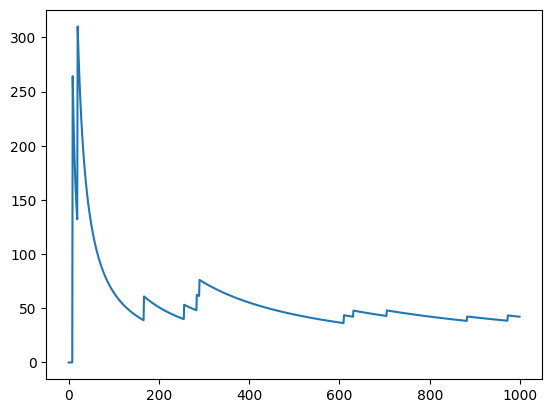

In [52]:
plt.plot(list(range(sim.total_time)), sim.scalability["TPS"])
plt.show()

In [52]:
import numpy as np
l = np.random.pareto(1.2,10000) + 1
print(min(l)/sum(l))
print(max(l)/sum(l))

1.391046789080585e-05
0.33116232474294943
